# Modeling AD Severity Score Dynamics

### This model is taken from the paper "“EczemaPred: A computational framework for personalised prediction of eczema severity dynamics" - Hurault G.

This is an introduction to EczemaPred, a collection of (Bayesian state-space) models that can be used to describe the data-generating mechanisms of each severity item. Each model assumes the existence of a true latent (unobserved) severity that follows its own latent dynamics and that the recorded severity was obtained as a result of imperfect measurement of the latent severity. Predictions for the different severity items can then be aggregated to produce predictions for the severity scores. Missing values were treated as an absence of measurement in the state-space models.

# Po-Scorad Model

![Alt Text](figures/EczemaPred.jpg)

*Model overview. (A) Bayesian state-space models in EczemaPred. Each model describes the dynamics of a latent severity (white ovals) and the measurement of the latent severity to obtain the recorded severity (grey ovals). (B) Use of EczemaPred for SCORAD prediction. Predictions from nine models (coloured rectangles), each of which corresponds to one of the nine severity items for SCORAD, are aggregated to provide predictions for SCORAD. (C) Latent dynamics and measurement distributions for the three severity components of SCORAD)*

### Extent Model for Lesional Patches

The extent model assumes that the body area is subdivided into 100 patches, each with a probability $ \hat{y}^{(k)}(t) $ of being classified as lesional. Each patch can transition between lesional and non-lesional states, and these transitions are described by a two-state Markov chain, referred to as the latent dynamic. 

The parameters of the Markov chain are patient-dependent and modeled with hierarchical priors. 

To measure the extent of the lesion, we use a binomial distribution to count the number of lesional patches, producing the extent score $ y $. This is expressed as:

$$
y^{(k)}(t) \sim \mathcal{B}(100, \hat{y}^{(k)}(t))
$$

where:
- $ y^{(k)}(t) $ is the number of lesional patches at time $ t $ for patch $ k $,
- $ \hat{y}^{(k)}(t) $ is the probability of the $ k^{th} $ patch being lesional at time $ t $.

### Code Example

To illustrate this model, let's create a simple simulation where we model the transitions of lesional patches over time, applying a two-state Markov chain. We'll also simulate a binomial measurement process to estimate the extent score for each patch.

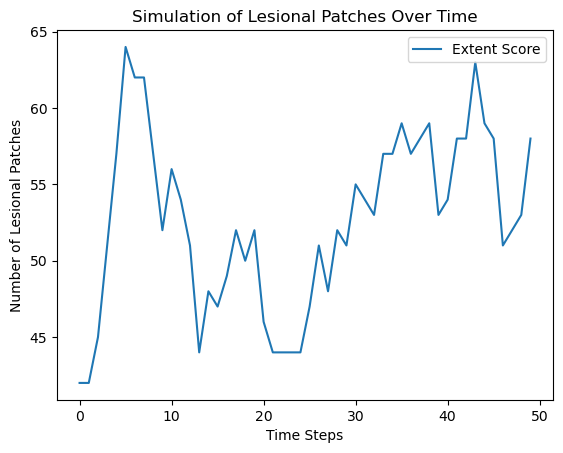

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Set parameters for the simulation
n_patches = 100  # Number of body patches
n_time_steps = 50  # Time steps for simulation
transition_prob = 0.1  # Probability of transitioning between lesional and non-lesional
initial_probability = 0.5  # Initial probability of being lesional

# Initialize the patches' status (0 = non-lesional, 1 = lesional)
patches = np.random.binomial(1, initial_probability, size=(n_patches, n_time_steps))

# Simulate the transitions using a Markov chain
for t in range(1, n_time_steps):
    for k in range(n_patches):
        # Transition rule: stay the same or flip state with probability 'transition_prob'
        if np.random.rand() < transition_prob:
            patches[k, t] = 1 - patches[k, t-1]  # Flip state (lesional <-> non-lesional)
        else:
            patches[k, t] = patches[k, t-1]  # Stay in the same state

# Calculate the extent score for each time step (binomial distribution)
extent_scores = np.sum(patches, axis=0)

# Plot the extent scores over time
plt.plot(range(n_time_steps), extent_scores, label="Extent Score")
plt.xlabel("Time Steps")
plt.ylabel("Number of Lesional Patches")
plt.title("Simulation of Lesional Patches Over Time")
plt.legend()
plt.show()

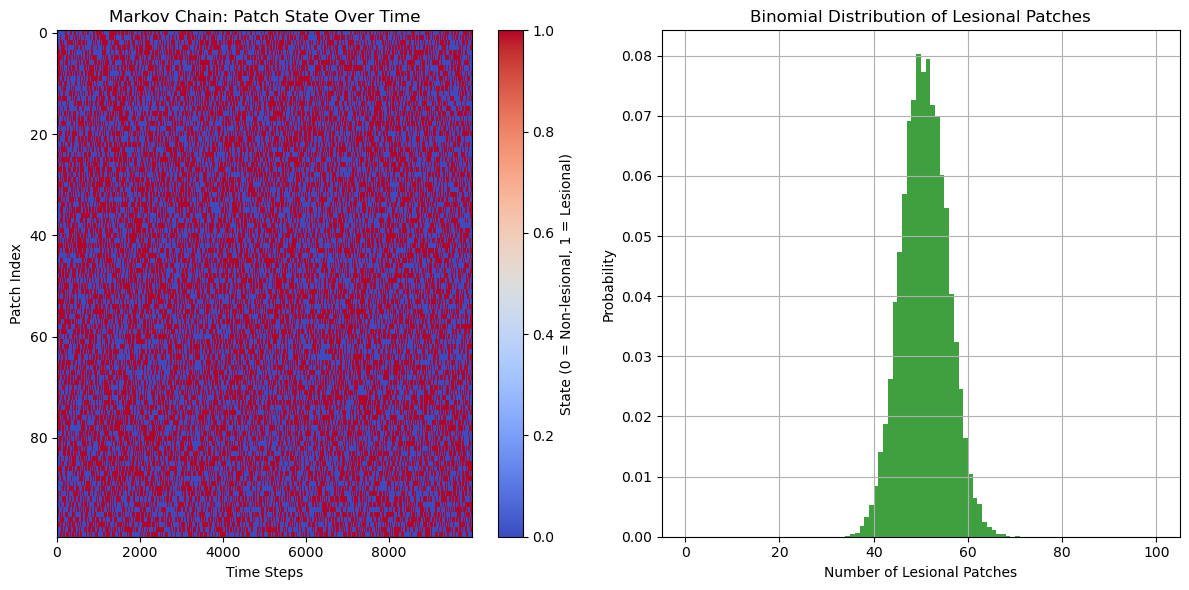

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Set parameters for the simulation
n_patches = 100  # Number of body patches
n_time_steps = 10000  # Time steps for simulation
transition_prob = 0.1  # Probability of transitioning between lesional and non-lesional
initial_probability = 0.5  # Initial probability of being lesional

# Initialize the patches' status (0 = non-lesional, 1 = lesional)
patches = np.random.binomial(1, initial_probability, size=(n_patches, n_time_steps))

# Simulate the transitions using a Markov chain
for t in range(1, n_time_steps):
    for k in range(n_patches):
        # Transition rule: stay the same or flip state with probability 'transition_prob'
        if np.random.rand() < transition_prob:
            patches[k, t] = 1 - patches[k, t-1]  # Flip state (lesional <-> non-lesional)
        else:
            patches[k, t] = patches[k, t-1]  # Stay in the same state

# Calculate the extent score for each time step (binomial distribution)
extent_scores = np.sum(patches, axis=0)

# Plot the Markov chain: State evolution of the patches over time
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(patches, aspect='auto', cmap='coolwarm', interpolation='nearest')
plt.title('Markov Chain: Patch State Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Patch Index')
plt.colorbar(label='State (0 = Non-lesional, 1 = Lesional)')

# Plot the extent scores (binomial distribution)
plt.subplot(1, 2, 2)
plt.hist(extent_scores, bins=np.arange(0, n_patches+1, 1), density=True, alpha=0.75, color='green')
plt.title('Binomial Distribution of Lesional Patches')
plt.xlabel('Number of Lesional Patches')
plt.ylabel('Probability')
plt.grid(True)

plt.tight_layout()
plt.show()


# State-Space Model for Intensity Signs and Subjective Symptoms

The state-space model for intensity signs and subjective symptoms is designed as a general-purpose framework, particularly useful when the data-generating mechanisms are not well understood. This model combines observation models, transformations, and dynamic processes to capture the temporal patterns and uncertainty inherent in such data.

---

## Components of the Model

### 1. Observation Model ($y_k(t)$):
The observed data $y_k(t)$ is modeled as being drawn from a distribution $\mathcal{D}$, which is parameterized by the latent score $\hat{y}_k(t)$:
$$
y_k(t) \sim \mathcal{D}(\hat{y}_k(t)).
$$
- **For subjective symptoms**: Given the high number of categories ($M + 1 = 101$), a **Binomial measurement distribution** with a logit link function is used.
- **For intensity signs**: Considering the smaller number of categories (\(M + 1 = 4\)), an **ordered logistic measurement distribution** with a linear link function is preferred for greater flexibility.
 

---

### 2. Link Function ($\hat{y}_k(t)$):
The latent score $\hat{y}_k(t)$ is derived from a transformed latent variable $\tilde{y}_k(t)$ through a function $g^{-1}(\cdot)$:
$$
\hat{y}_k(t) = g(\tilde{y}_k(t)).
$$
- The choice of the link function $g$ depends on the measurement distribution $\mathcal{D}$. For example:
  - For the **Binomial distribution**, the logit link is employed ($g^{-1}$ is the logistic sigmoid function).
  - For the **ordered logistic distribution**, a linear link is used.

---

### 3. Dynamic Model ($\tilde{y}_k(t)$):
The transformed latent variable $\tilde{y}_k(t)$ evolves over time according to a random walk, capturing the temporal dynamics and uncertainty:
$$
\tilde{y}_k(t+1) \sim \mathcal{N}(\tilde{y}_k(t), \sigma^2).
$$
This dynamic process models the changes in the underlying latent variable, allowing for smooth transitions over time while incorporating variability ($\sigma^2$).

---

### 4. Initial Condition ($\tilde{y}_k(t_0)$):
At the starting time $t_0$, the transformed latent variable $\tilde{y}_k(t_0)$ is assumed to follow a normal distribution with a predefined mean ($\mu_0$) and variance ($\sigma_0^2$):
$$
\tilde{y}_k(t_0) \sim \mathcal{N}(\mu_0, \sigma_0^2).
$$
This prior distribution provides a baseline for the latent variable at the initial time step.

---

## Key Characteristics of the Model:
- **Flexibility**: The choice of measurement distributions and link functions allows the model to adapt to different types of ordinal data.
- **Temporal Dynamics**: The random walk in the dynamic model captures smooth changes over time.
- **Domain-Specific Customization**: For subjective symptoms, the Binomial distribution is used due to the large category count, while the ordered logistic distribution is chosen for intensity signs to leverage its flexibility.

This state-space approach provides a robust framework for modeling both the observed data and the latent dynamics, making it well-suited for applications in medical or behavioral studies.


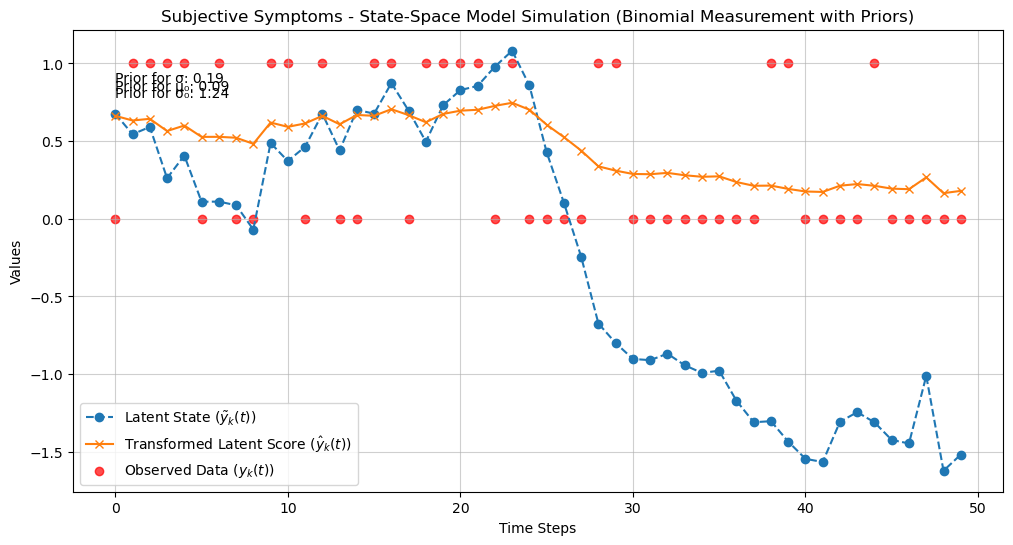

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 50  # Number of time steps
sigma = 0.5  # Standard deviation of random walk for latent variable (will be adjusted by prior)
mu0, sigma0 = 0, 1  # Initial conditions for the latent variable (prior for mu_0)

# Correct prior for sigma to ensure it's positive
prior_sigma = np.abs(np.random.normal(0, 0.25 * np.log(5)))  # Ensure positive standard deviation for the random walk

prior_mu0 = np.random.normal(0, 1, size=1)[0]  # Prior for mu_0 (initial latent state)
prior_sigma0 = np.abs(np.random.normal(0, 1.5, size=1)[0])  # Ensure positive prior for sigma_0

# Latent state random walk (y_tilde)
np.random.seed(12)
y_tilde = [np.random.normal(prior_mu0, prior_sigma0)]  # Initialize latent variable using prior for mu_0
for t in range(1, T):
    y_tilde.append(np.random.normal(y_tilde[-1], prior_sigma))  # Apply random walk with prior sigma

y_tilde = np.array(y_tilde)

# Apply logit link function: g^-1(y_tilde) = 1 / (1 + exp(-y_tilde))
# To transform the latent variable to a probability between 0 and 1
p = 1 / (1 + np.exp(-y_tilde))

# Observation model (Binomial): Simulate observed data based on Bernoulli trials
# For simplicity, we assume a binomial distribution with p as the success probability
y_obs = np.random.binomial(1, p)  # 1 for success (observed event), 0 for failure

# Plot the results
plt.figure(figsize=(12, 6))

# Plot the latent state (y_tilde)
plt.plot(y_tilde, label=r"Latent State ($\tilde{y}_k(t)$)", linestyle="--", marker="o")

# Plot the transformed latent scores (p, which are probabilities)
plt.plot(p, label="Transformed Latent Score ($\hat{y}_k(t)$)", linestyle="-", marker="x")

# Plot the observed data
plt.scatter(range(T), y_obs, label="Observed Data ($y_k(t)$)", color="red", alpha=0.7)

# Add information for priors and model description
plt.text(0, 0.95, f"Prior for σ: {prior_sigma:.2f}", fontsize=10, color="black", verticalalignment="top")
plt.text(0, 0.90, f"Prior for μ₀: {prior_mu0:.2f}", fontsize=10, color="black", verticalalignment="top")
plt.text(0, 0.85, f"Prior for σ₀: {prior_sigma0:.2f}", fontsize=10, color="black", verticalalignment="top")

plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.title("Subjective Symptoms - State-Space Model Simulation (Binomial Measurement with Priors)")
plt.legend()
plt.grid(alpha=0.6)
plt.show()


# For intensity signs
Intensity signs have a small number of categories (𝑀 + 1 = 4), we preferred to choose an ordered logistic measurement distribution, what is that ?

## Ordered Logistic Distribution

### Definition

For a discrete ordinal outcome $ y \in \{0, ..., M\} $ (with $ M + 1 $ categories), the **probability mass function (PMF)** of the ordered logistic distribution is defined as:

$$
P(y | \eta, c) =
\begin{cases} 
1 - \text{logit}^{-1}(\eta - c_1), & \text{if } y = 0 \\
\text{logit}^{-1}(\eta - c_y) - \text{logit}^{-1}(\eta - c_{y+1}), & \text{if } 0 < y < M \\
\text{logit}^{-1}(\eta - c_M), & \text{if } y = M
\end{cases}
$$

Here:
- $ \eta $: the **location** of the distribution.
- $ c $: a vector of size $ M $ representing the **cut-offs**.

---

### Explanation

The **ordered logistic distribution** is derived from a logistic distribution with:
- **Location**: $ \eta $, which determines where the distribution is centered.
- **Scale**: 1 (fixed).

The logistic distribution has a **logistic cumulative distribution function (CDF)**, which is used to define the cut-offs $ c_1, c_2, ..., c_M $. The ordered logistic distribution is created by **discretizing** the logistic distribution using these cut-offs. 

#### Probability of $ y $
- The probability of observing $ y $ is the **area under the logistic distribution** between the $ y $-th and the $ y + 1 $-th cut-offs.
- For example:
  - $ P(y = 0) $: Area to the left of the first cut-off $ c_1 $.
  - $ P(0 < y < M) $: Area between two consecutive cut-offs $ c_y $ and $ c_{y+1} $.
  - $ P(y = M) $: Area to the right of the last cut-off $ c_M $.

#### Equation Reformulation
We can rewrite the ordered logistic distribution as:
- First, model the latent continuous variable $ \hat{y} $:
  $$
  \hat{y} \sim \text{Logistic}(\eta, 1).
  $$
- Then discretize $ \hat{y} $ into $ y $ based on the cut-offs:
  $$
  y =
  \begin{cases} 
  0, & \hat{y} < c_1 \\
  i, & c_i < \hat{y} < c_{i+1}, \text{ for } 0 < i < M \\
  M, & \hat{y} > c_M
  \end{cases}
  $$

---

### Key Intuition
The ordered logistic distribution:
1. **Models the latent variable $ \hat{y} $**: A continuous variable following a logistic distribution.
2. **Thresholds $ \hat{y} $ using cut-offs $ c $**: Produces an ordinal outcome $ y $, with the probability of each category determined by the logistic distribution's CDF evaluated at the cut-offs.


## Difference Between $ \hat{y} $ and $ y $

### 1. What is the difference between $ \hat{y} $ and $ y $?

- **$ \hat{y} $ (Latent Variable)**:
  - $ \hat{y} $ is the **latent continuous score** before we apply the thresholds to discretize it.
  - This is typically modeled using a **logistic distribution** (or another distribution like normal) because it's a continuous quantity that represents some underlying severity or measure, but it's not yet categorized.
  - For example, $ \hat{y} $ could represent a real-valued intensity score of a symptom, but in its raw form, it's continuous, not ordinal.

- **$ y $ (Observed/Discrete Variable)**:
  - $ y $ is the **observed outcome** or the **discrete ordinal category** that we actually record or measure.
  - This is what we see in practice: an integer value (e.g., 0, 1, 2, 3) representing different severity levels of a symptom.
  - To get $ y $, we use the **cut-off thresholds** (denoted by $ c_1, c_2, ..., c_M $) to discretize the continuous $ \hat{y} $.

---

### 2. Why is $ y $ taken from an **Ordered Logistic Distribution** and $ \hat{y} $ from a **Logistic Distribution**?

The key idea here is that $ \hat{y} $ is a **latent continuous variable** (i.e., something we cannot observe directly but we model it using a logistic distribution), while $ y $ is a **discrete observation** (i.e., something we can actually observe or measure in a finite set of categories).

#### Logistic Distribution for $ \hat{y} $ (Latent Variable):
- The latent variable $ \hat{y} $ represents the **underlying intensity** of a symptom, which is continuous. For example, a score between 0 and 10 could represent the severity of a symptom.
- We assume this latent variable follows a **logistic distribution** because the logistic distribution is often used in situations where we have continuous data that is related to an underlying process (such as in logistic regression models).
  
#### Ordered Logistic Distribution for $ y $ (Observed Variable):
- **$ y $** is the **discretized version** of $ \hat{y} $, and its values are **ordinal**. For example, instead of a continuous scale from 0 to 10, we have predefined categories such as:
  - $ y = 0 $ (no symptoms)
  - $ y = 1 $ (mild symptoms)
  - $ y = 2 $ (moderate symptoms)
  - $ y = 3 $ (severe symptoms)
  
- To map the continuous latent variable $ \hat{y} $ into these discrete categories, we use an **ordered logistic distribution**, which takes into account the **cut-offs** that define the thresholds between categories.

---


### 4. Summary:
- **$ \hat{y} $** represents an **underlying continuous latent score** that we can't directly observe but model using a continuous distribution (logistic distribution).
- **$ y $** is the **discretized observed outcome**, which is categorical and follows an **ordered logistic distribution** to model how we categorize the continuous scores.

This distinction allows us to use **continuous models** to estimate the underlying severity of a symptom, but still **categorize** it into discrete levels that we can use for reporting, diagnosis, or further analysis.


C:\Users\Pierre\AppData\Local\Temp\ipykernel_29680\1577626780.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


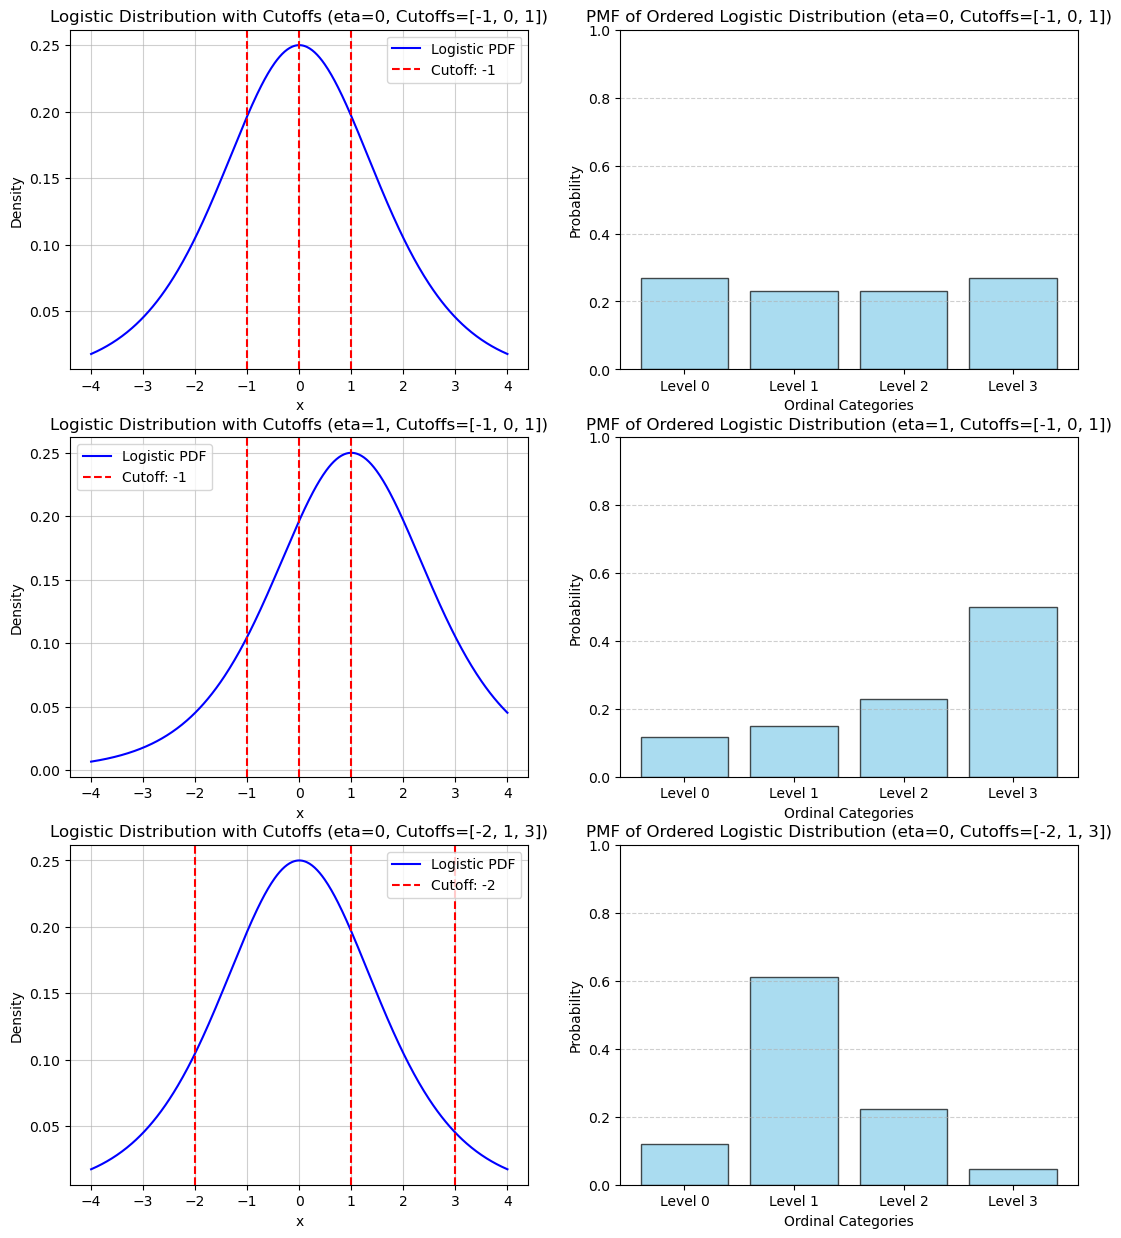

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit  # Logistic sigmoid function

# Function to calculate the PMF for an ordered logistic distribution
def ordered_logistic_pmf(eta, cutoffs, M):
    probabilities = []
    for y in range(M + 1):
        if y == 0:
            p = 1 - expit(eta - cutoffs[0])
        elif y < M:
            p = expit(eta - cutoffs[y - 1]) - expit(eta - cutoffs[y])
        else:  # y == M
            p = expit(eta - cutoffs[M - 1])
        probabilities.append(p)
    return np.array(probabilities)

# Logistic PDF function
def logistic_pdf(x, eta, scale=1):
    z = (x - eta) / scale
    return np.exp(-z) / (scale * (1 + np.exp(-z))**2)

# Generate x values for the logistic PDF
x_values = np.linspace(-4, 4, 500)

# Plotting function
def plot_ordered_logistic(eta, cutoffs, M, ax1, ax2, title_suffix):
    # Compute PMF and PDF values
    pmf_values = ordered_logistic_pmf(eta, cutoffs, M)
    pdf_values = logistic_pdf(x_values, eta=eta)
    
    # Top Panel: Logistic PDF with cutoffs
    ax1.plot(x_values, pdf_values, label="Logistic PDF", color="blue")
    for cutoff in cutoffs:
        ax1.axvline(cutoff, color="red", linestyle="--", label=f"Cutoff: {cutoff}" if cutoff == cutoffs[0] else None)
    ax1.set_title(f"Logistic Distribution with Cutoffs ({title_suffix})")
    ax1.set_xlabel("x")
    ax1.set_ylabel("Density")
    ax1.legend()
    ax1.grid(alpha=0.6)
    
    # Bottom Panel: PMF of the ordered logistic distribution
    categories = np.arange(M + 1)
    ax2.bar(categories, pmf_values, color='skyblue', edgecolor='black', alpha=0.7)
    ax2.set_xticks(categories)
    ax2.set_xticklabels([f"Level {i}" for i in categories])
    ax2.set_xlabel("Ordinal Categories")
    ax2.set_ylabel("Probability")
    ax2.set_title(f"PMF of Ordered Logistic Distribution ({title_suffix})")
    ax2.set_ylim(0, 1)
    ax2.grid(axis='y', linestyle='--', alpha=0.6)

# Parameters for the plots
M = 3  # Number of levels
scenarios = [
    {"eta": 0, "cutoffs": [-1, 0, 1], "title_suffix": "eta=0, Cutoffs=[-1, 0, 1]"},
    {"eta": 1, "cutoffs": [-1, 0, 1], "title_suffix": "eta=1, Cutoffs=[-1, 0, 1]"},
    {"eta": 0, "cutoffs": [-2, 1, 3], "title_suffix": "eta=0, Cutoffs=[-2, 1, 3]"},
]

# Create plots
fig, axes = plt.subplots(3, 2, figsize=(13, 15), gridspec_kw={"hspace": 0.2})
for i, scenario in enumerate(scenarios):
    plot_ordered_logistic(
        eta=scenario["eta"],
        cutoffs=scenario["cutoffs"],
        M=M,
        ax1=axes[i, 0],
        ax2=axes[i, 1],
        title_suffix=scenario["title_suffix"]
    )

# Show the combined plots
plt.tight_layout()
plt.show()
